In [5]:
#Country of focus
countries = ['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belize', 'Benin', 'Bhutan','Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Comoros', 'Congo','Congo, Democratic Republic', 'Costa Rica', 'Croatia', "Côte d'Ivoire", 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Fiji', 'Gabon', 'Gambia', 'Georgia', 'Ghana', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India', 'Indonesia', 'Iran (Islamic Republic of)', 'Iraq', 'Jamaica', 'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kosovo', 'Kyrgyzstan', "Lao People's Democratic Republic", 'Lebanon', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives', 'Mali', 'Marshall Islands', 'Mauritania', 'Mauritius', 'Mexico', 'Micronesia (Federated States of)','Moldova', 'Mongolia', 'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia', 'Nauru', 'Nepal', 'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia', 'Pakistan', 'Palau', 'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines', 'Poland', 'Romania', 'Russian Federation', 'Rwanda', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Samoa', 'Sao Tome and Principe', 'Senegal', 'Serbia', 'Seychelles', 'Sierra Leone', 'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan', 'Sri Lanka', 'Sudan', 'Suriname', 'Syrian Arab Republic', 'Tajikistan', 'Thailand', 'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia', 'Turkey', 'Turkmenistan', 'Tuvalu', 'Uganda', 'Ukraine', 'United Republic of Tanzania', 'Uruguay', 'Uzbekistan', 'Vanuatu','Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import collections
import itertools

from sklearn import preprocessing
from sklearn import metrics
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
Goal4 = pd.read_excel('Goal4.xlsx')

**Data Preprocessing**

In [9]:
data = Goal4[Goal4["GeoAreaName"].isin(countries)]

In [10]:
data = data.loc[data['Indicator'] == '4.4.1']

In [11]:
# data subset
data = data[['Value','GeoAreaName','TimePeriod','Sex', 'Type of skill']] #'Education level','Location',
# change colnames
data.rename(columns = {'GeoAreaName' : 'Country', 'TimePeriod' : 'Year', 'Type of skill' : 'Skill'}, inplace = True)
#'Education level' : 'Level'

In [12]:
# remove NAs
data = data.dropna()

In [13]:
data.dtypes

Value      float64
Country     object
Year         int64
Sex         object
Skill       object
dtype: object

In [14]:
print(data.shape)
data.head()

(2811, 5)


,Value,Country,Year,Sex,Skill
87476,16.12054,Albania,2019,BOTHSEX,COPA
87477,13.89042,Albania,2019,BOTHSEX,SOFT
87478,12.57493,Albania,2019,FEMALE,SOFT
87479,21.55040,Albania,2019,MALE,TRAF
87480,1.35666,Albania,2019,FEMALE,PCPR


In [15]:
data.describe()

,Value,Year
count,2811.000000,2811.000000
mean,20.876142,2016.922448
std,16.481385,1.614337
min,0.013830,2014.000000
25%,7.049675,2016.000000
50%,17.755920,2017.000000
75%,30.633755,2018.000000
max,72.801010,2019.000000


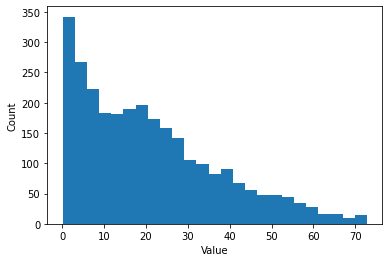

In [16]:
plt.hist(data['Value'], bins = 25)
plt.xlabel('Value')
_ = plt.ylabel('Count')

In [17]:
print(data['Year'].min())
print(data['Year'].max())

2014
2019


In [18]:
# train test split
data_train = data.loc[data['Year'] != 2019]
data_test = data.loc[data['Year'] == 2019]

In [19]:
# construct X and y
y_train = data_train.iloc[:,0]
y_test = data_test.iloc[:,0]
X_train = data_train.loc[:, ~data_train.columns.isin(['Value'])]
X_test = data_test.loc[:, ~data_test.columns.isin(['Value'])]

In [20]:
# dummy variables for categorical columns
obj_X_train = X_train.select_dtypes(include=['object']).copy()
obj_X_train = pd.get_dummies(obj_X_train, dummy_na=True)

obj_X_test = X_test.select_dtypes(include=['object']).copy()
obj_X_test = pd.get_dummies(obj_X_test, dummy_na=True)

In [21]:
# impute with mean numerical columns
not_obj_X_train = X_train.select_dtypes(exclude=['object']).copy()
num_col = not_obj_X_train.columns
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
not_obj_X_train[:] = imp.fit_transform(not_obj_X_train)

not_obj_X_test = X_test.select_dtypes(exclude=['object']).copy()
num_col = not_obj_X_test.columns
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
not_obj_X_test[:] = imp.fit_transform(not_obj_X_test)

In [22]:
# construct X again
Xt_train = pd.concat([not_obj_X_train, obj_X_train], axis=1)
Xt_test = pd.concat([not_obj_X_test, obj_X_test], axis=1)

In [23]:
# scale y
y_train = y_train.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

target_scaler = StandardScaler()
target_scaler.fit(y_train)

y_train = target_scaler.transform(y_train)
y_test = target_scaler.transform(y_test)

In [24]:
miss_test = Xt_train.columns.difference(Xt_test.columns)
miss_train = Xt_test.columns.difference(Xt_train.columns)

In [25]:
for i in miss_test:
    Xt_test[i] = 0
    
for i in miss_train:    
    Xt_train[i] = 0

In [26]:
print(y_train.shape)
print(Xt_train.shape)

(2233, 1)
(2233, 76)


In [27]:
print(y_test.shape)
print(Xt_test.shape)

(578, 1)
(578, 76)


**KNN**

In [28]:
# preprocessing data
X_train_knn = Xt_train.copy()
X_test_knn = Xt_test.copy()
y_train_knn = y_train.copy()
y_test_knn = y_test.copy()

scaler = StandardScaler()  
scaler.fit(X_train_knn[num_col]) # scaling only numerical variables

X_train_knn[num_col] = scaler.transform(X_train_knn[num_col])  
X_test_knn[num_col] = scaler.transform(X_test_knn[num_col]) 

In [29]:
# cv of hyperparameters
params_knn = {'n_neighbors':[int(x) for x in np.linspace(start = 1, stop = 25, num = 5)]} # number of neighbors

# fit
knn = KNeighborsRegressor()
model_knn = GridSearchCV(knn, params_knn, cv=2)
model_knn.fit(X_train_knn,y_train_knn)
print("best hyperparameters:", model_knn.best_params_)
print("best score:", model_knn.best_score_)

# predict
y_pred_knn = model_knn.predict(X_test_knn)
mse_knn = ((y_pred_knn - y_test_knn)**2).mean()
print("MSE:", mse_knn)

best hyperparameters: {'n_neighbors': 19}
best score: 0.2583834027764138
MSE: 1.5143955929108064


**SVM**

In [30]:
# preprocessing data
X_train_svm = Xt_train.copy()
X_test_svm = Xt_test.copy()
y_train_svm = y_train.copy()
y_test_svm = y_test.copy()

scaler = StandardScaler()  
scaler.fit(X_train_svm[num_col]) # scaling only numerical variables

X_train_svm[num_col] = scaler.transform(X_train_svm[num_col])  
X_test_svm[num_col] = scaler.transform(X_test_svm[num_col]) 

In [31]:
# cv of hyperparameters
C_range = 10. ** np.arange(-3, 4)
gamma_range = 10. ** np.arange(-3, 4)
params_svm = dict(gamma=gamma_range, C=C_range)

In [34]:
# fit
svm1 = SVR(kernel='rbf')
model_svm1 = GridSearchCV(svm1, params_svm, cv=5)
model_svm1.fit(X_train_svm,y_train_svm)
print("best hyperparameters:", model_svm1.best_params_)
print("best score:", model_svm1.best_score_)

# predict
y_pred_svm1 = model_svm1.predict(X_test_svm)
mse_svm1 = ((y_pred_svm1 - y_test_svm)**2).mean()
print("MSE:", mse_svm1)

best hyperparameters: {'C': 1000.0, 'gamma': 0.1}
best score: 0.32398167596983857
MSE: 2.9042680310476214


In [35]:
# fit
svm2 = SVR(kernel='sigmoid')
model_svm2 = GridSearchCV(svm2, params_svm, cv=5)
model_svm2.fit(X_train_svm,y_train_svm)
print("best hyperparameters:", model_svm2.best_params_)
print("best score:", model_svm2.best_score_)

# predict
y_pred_svm2 = model_svm2.predict(X_test_svm)
mse_svm2 = ((y_pred_svm2 - y_test_svm)**2).mean()
print("MSE:", mse_svm2)

best hyperparameters: {'C': 100.0, 'gamma': 0.001}
best score: 0.29066823672925884
MSE: 2.0641975616191472


In [36]:
baseline_pred = [np.average(y_test)] * len(y_test)
baseline_pred = np.array(baseline_pred)
baseline_pred = baseline_pred.reshape(-1,1)
mse_baseline = ((baseline_pred - y_test)**2).mean()
print(mse_baseline)

1.0381759520079339


In [37]:
print('MODEL NAME                    | MSE')
print('-'*50)
print("Baseline                      | {:.5f}".format(mse_baseline))
print("KNN                           | {:.5f}".format(mse_knn))
print("SVM RBF fitting               | {:.5f}".format(mse_svm1))
print("SVM sigmoid fitting           | {:.5f}".format(mse_svm2))


MODEL NAME                    | MSE
--------------------------------------------------
Baseline                      | 1.03818
KNN                           | 1.51440
SVM RBF fitting               | 2.90427
SVM sigmoid fitting           | 2.06420


**Results**

In [38]:
# revret y scaling
y_test_knn_rev = target_scaler.inverse_transform(y_test_knn)
y_pred_knn_rev = target_scaler.inverse_transform(y_pred_knn)

In [39]:
# create result df
res = X_test_knn

In [40]:
# revret X dummies
# https://stackoverflow.com/questions/34523111/the-most-elegant-way-to-get-back-from-pandas-df-dummies
from collections import defaultdict
pos = defaultdict(list)
vals = defaultdict(list)

for i, c in enumerate(res.columns):
    if "_" in c:
        k, v = c.split("_", 1)
        pos[k].append(i)
        vals[k].append(v)
    else:
        pos["_"].append(i)
        
        
#res.iloc[:, pos["Country"]]
#np.argmax(res.iloc[:, pos["Country"]].values, axis=1)
#pd.Categorical.from_codes(np.argmax(res.iloc[:, pos["Country"]].values, axis=1), vals["Country"])
res = pd.DataFrame({k: pd.Categorical.from_codes(np.argmax(res.iloc[:, pos[k]].values, axis=1), vals[k]) for k in vals})

In [41]:
# add results to df
res['value_test'] = y_test_knn_rev
res['value_pred'] = y_pred_knn_rev

In [42]:
# group by skill
res_skill = res.groupby(['Skill']).mean()
res_skill.reset_index(inplace=True)
res_skill = res_skill.iloc[:-1 , :]
res_skill

,Skill,value_test,value_pred
0,ARSP,17.634125,25.209705
1,CMFL,33.702164,17.832297
2,COPA,29.558606,20.361819
3,EMAIL,28.819391,20.881371
4,EPRS,15.529722,12.518412
5,INST,15.434085,14.978010
6,PCPR,3.468892,17.284517
7,SOFT,18.511188,13.458713
8,TRAF,29.670136,12.197727


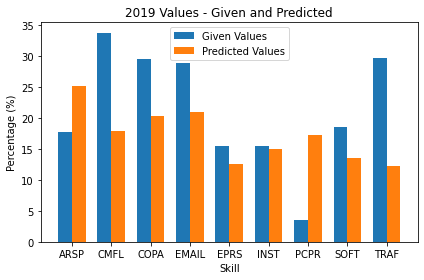

In [51]:
x = np.arange(len(res_skill.Skill))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, res_skill.value_test, width, label='Given Values')
rects2 = ax.bar(x + width/2, res_skill.value_pred, width, label='Predicted Values')

ax.set_ylabel('Percentage (%)')
ax.set_xlabel('Skill')
ax.set_title('2019 Values - Given and Predicted')
ax.set_xticks(x)
ax.set_xticklabels(res_skill.Skill)
ax.legend()

fig.tight_layout()

plt.show()

In [47]:
data['Skill'].value_counts()
#data.groupby(["Skill", "Country"]).size().reset_index(name="Count")

EPRS     366
TRAF     351
ARSP     331
PCPR     329
CMFL     315
SOFT     307
COPA     296
INST     262
EMAIL    254
Name: Skill, dtype: int64